[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Train Soccer Ball Detector

---

[![Download Dataset](https://app.roboflow.com/images/download-dataset-badge.svg)](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc)

This notebook is based on the [How to Train YOLOv8 Object Detection on a Custom Dataset](https://github.com/roboflow/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb) notebook from the [roboflow/notebooks](https://github.com/roboflow/notebooks) repository.

## Configure API keys

- Open your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑). Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Oct 27 21:43:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 581.42                 Driver Version: 581.42         CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   50C    P8              3W /   80W |     697MiB /   8188MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

c:\Player Detection\roboflow_sports_footar\notebooks


## Install dependencies

In [3]:
!pip install -q ultralytics roboflow

## Imports

In [4]:
from roboflow import Roboflow
from IPython.display import Image

## Pull dataset

In [ ]:
import os

# Cria diretório para datasets se não existir
os.makedirs(f"{HOME}/datasets", exist_ok=True)
os.chdir(f"{HOME}/datasets")

# Coloca aqui a tua API key do Roboflow (https://app.roboflow.com/settings/api)
ROBOFLOW_API_KEY = "jkYtD2E46FGW8fxybHJm"  # ← Substitui isto pela tua chave
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("roboflow-jvuqo").project("football-ball-detection-rejhg")
version = project.version(2)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
loading Roboflow project...


**NOTE:** Update `data.yaml` structure to align with the latest requirements of the `ultralytics` package.



In [6]:
# Atualiza o data.yaml para o formato correto do ultralytics
import re

data_yaml_path = f"{dataset.location}/data.yaml"

with open(data_yaml_path, 'r') as f:
    content = f.read()

# Substitui os caminhos para o formato correto
content = re.sub(r'train:.*', 'train: ../train/images', content)
content = re.sub(r'val:.*', 'val: ../valid/images', content)

with open(data_yaml_path, 'w') as f:
    f.write(content)

print(f"✓ data.yaml atualizado em {data_yaml_path}")

✓ data.yaml atualizado em c:\Player Detection\roboflow_sports_footar\notebooks\datasets\football-ball-detection-2/data.yaml


## Custom training - Optimized Configuration

**Melhorias aplicadas:**
- ✅ **epochs: 100** (antes 50) - Mais tempo de treino para melhorar recall
- ✅ **imgsz: 1280** (antes 640) - Detecta bolas menores e mais distantes
- ✅ **batch: 2** (antes 4) - Ajustado para imgsz maior (evita OOM)
- ✅ **patience: 20** - Early stopping se não melhorar
- ✅ **save_period: 10** - Checkpoints a cada 10 epochs

**Problema anterior:** Recall 30% (modelo perdia 70% das bolas)

**Objetivo:** Recall > 60%, mAP50 > 50%

In [7]:
import os
from ultralytics import YOLO

os.chdir(HOME)

# Treino com YOLOv12 usando API Python - mais confiável que CLI
data_path = f"{dataset.location}/data.yaml"
project_dir = os.path.join(HOME, "runs", "detect")  # controla onde guardar resultados

model = YOLO('yolo12s.pt')
results = model.train(
    data=data_path,
    epochs=100,         # ← Aumentado de 50 para 100 (melhor recall)
    imgsz=1280,         # ← Aumentado de 640 para 1280 (detecta bolas menores/distantes)
    batch=2,            # ← Reduzido de 4 para 2 (imgsz maior = mais memória)
    plots=True,
    workers=0,
    device=0,           # força GPU 0
    project=project_dir,
    name="train_ball_y12s_optimized",  # novo nome para diferenciar
    patience=20,        # ← Early stopping se não melhorar em 20 epochs
    save_period=10,     # ← Salva checkpoint a cada 10 epochs
    seed=0
)

Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\Player Detection\roboflow_sports_footar\notebooks\datasets\football-ball-detection-2/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_ball_y12s_optimized2, nbs=64, nms=False, o

In [8]:
# Caminho do run atual (dinâmico)
RUN_DIR = str(results.save_dir).replace('\\', '/')
print("RUN_DIR:", RUN_DIR)

import os
print("Conteúdo:", os.listdir(RUN_DIR))

RUN_DIR: C:/Player Detection/roboflow_sports_footar/notebooks/runs/detect/train_ball_y12s_optimized2
Conteúdo: ['args.yaml', 'BoxF1_curve.png', 'BoxPR_curve.png', 'BoxP_curve.png', 'BoxR_curve.png', 'confusion_matrix.png', 'confusion_matrix_normalized.png', 'labels.jpg', 'results.csv', 'results.png', 'train_batch0.jpg', 'train_batch1.jpg', 'train_batch2.jpg', 'train_batch88470.jpg', 'train_batch88471.jpg', 'train_batch88472.jpg', 'val_batch0_labels.jpg', 'val_batch0_pred.jpg', 'val_batch1_labels.jpg', 'val_batch1_pred.jpg', 'val_batch2_labels.jpg', 'val_batch2_pred.jpg', 'weights']


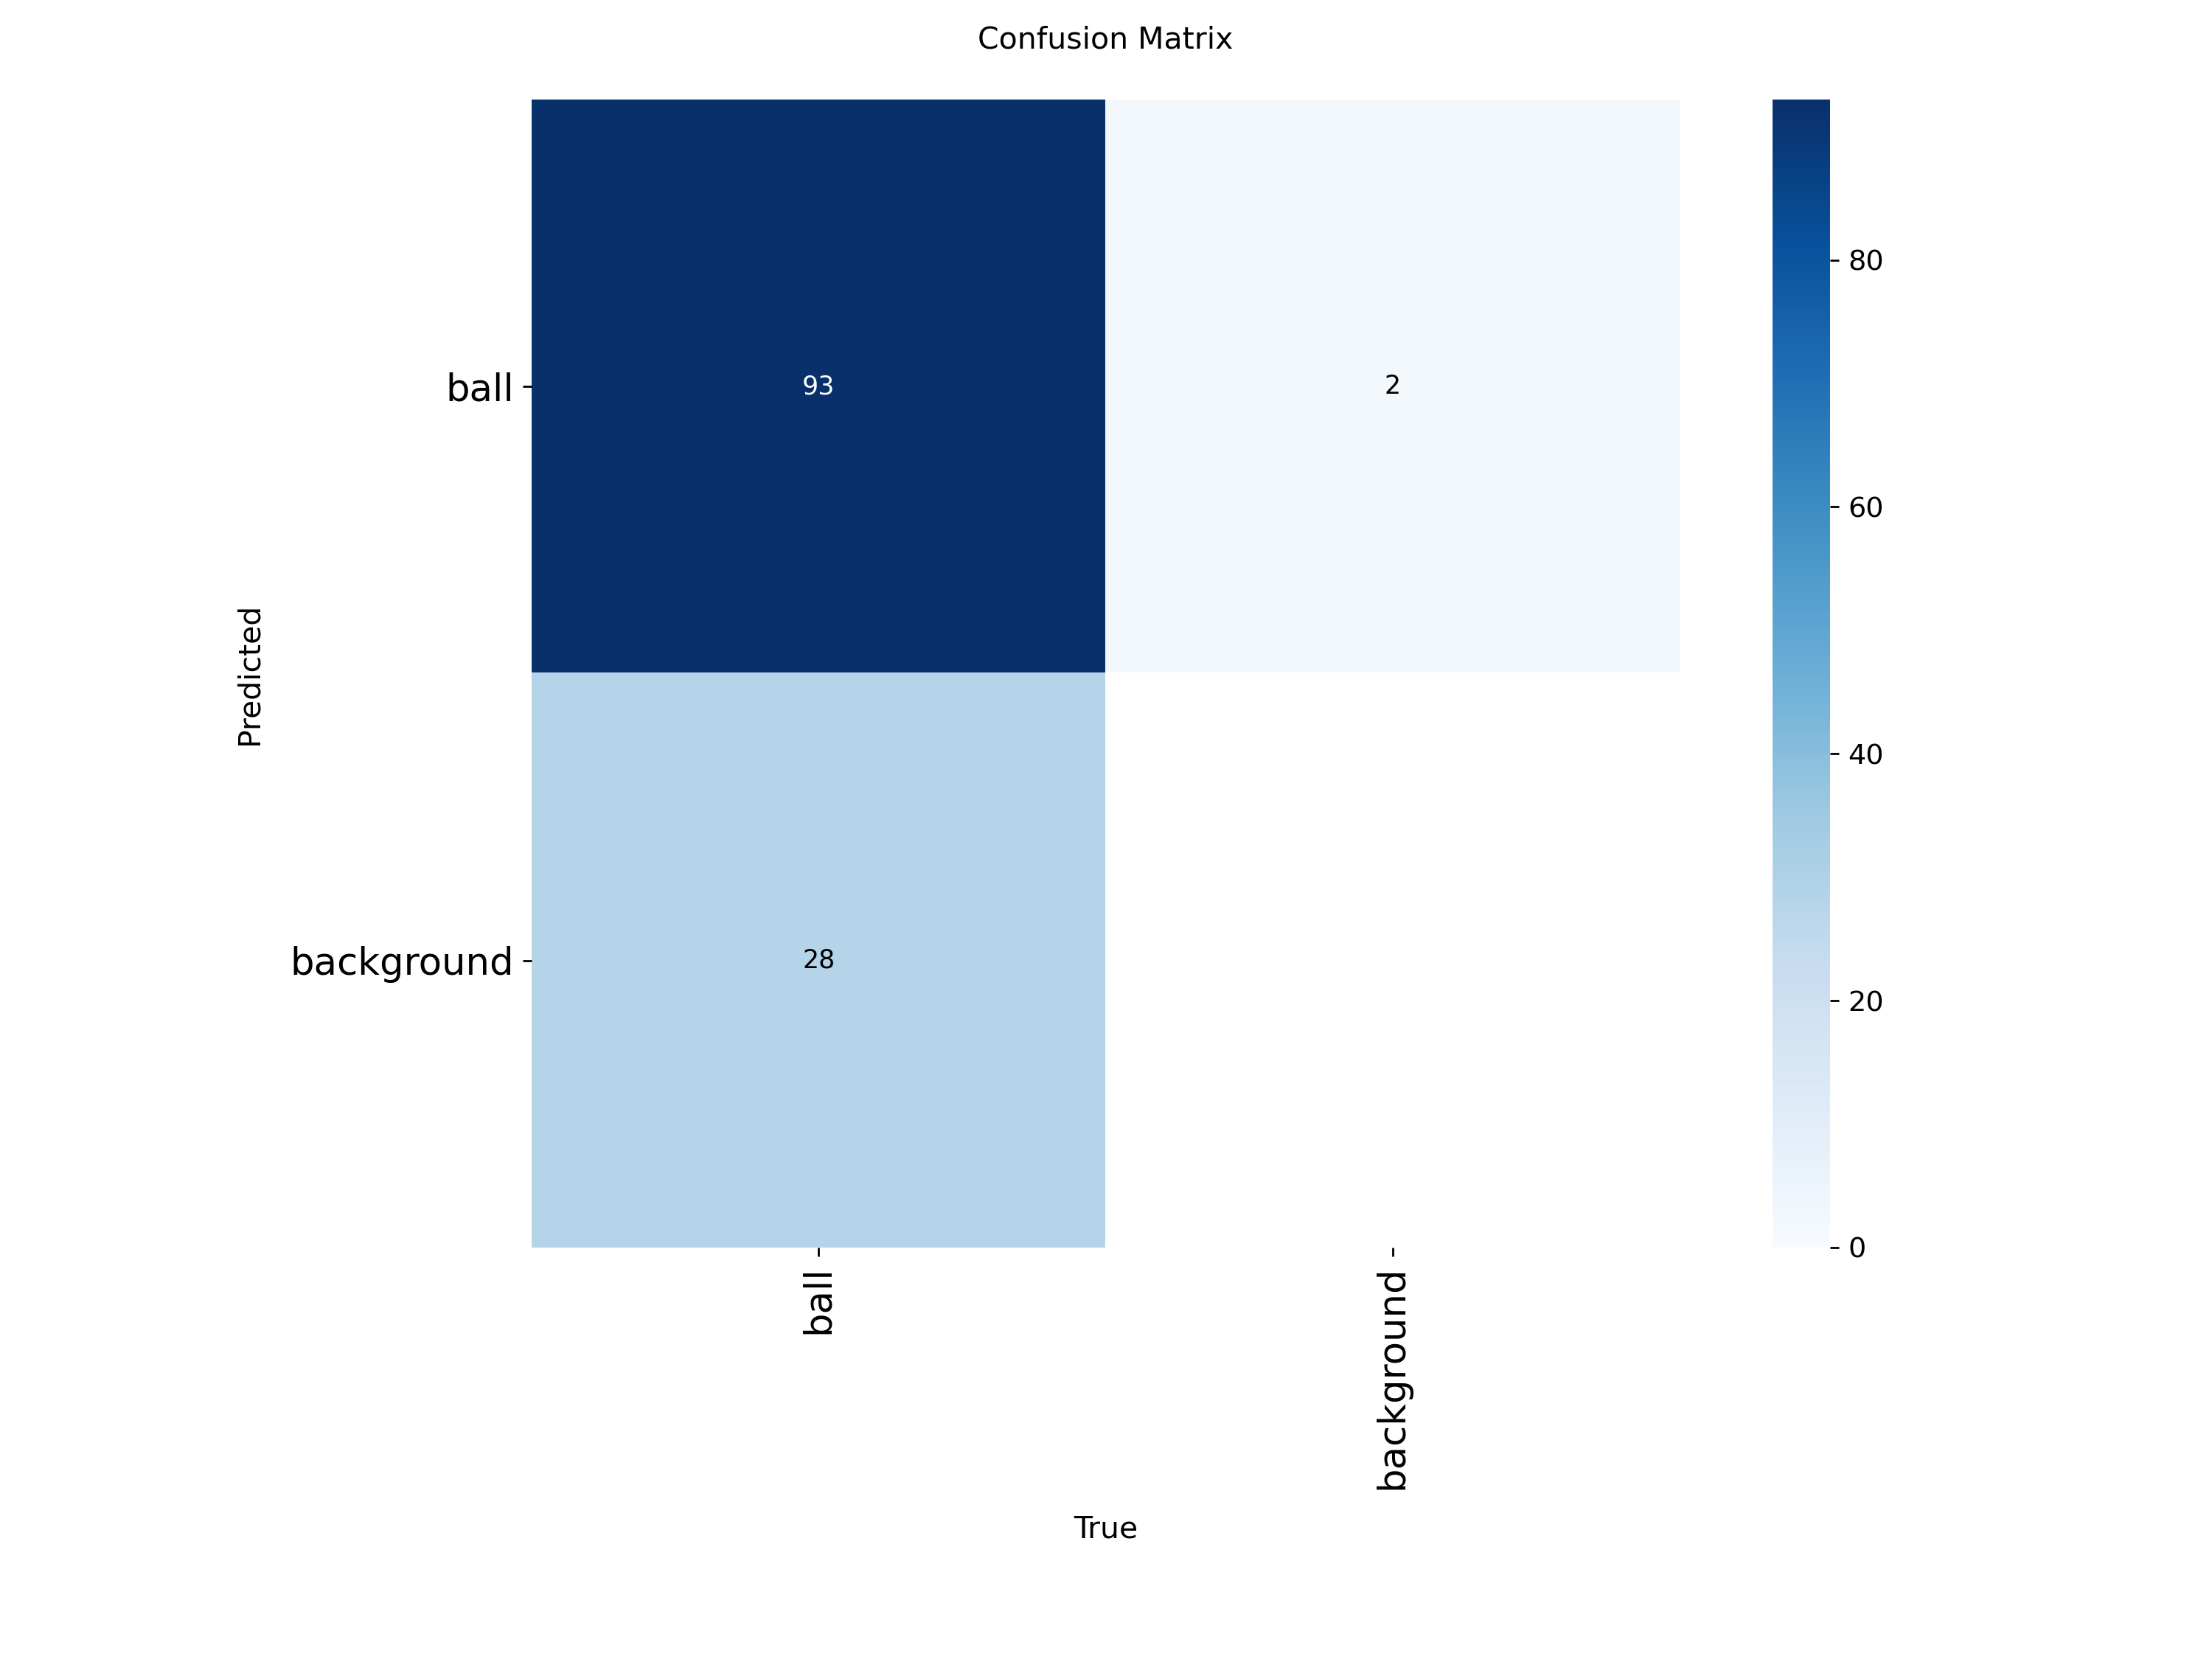

In [9]:
from IPython.display import Image, display
# Mostra matriz de confusão
display(Image(filename=f"{RUN_DIR}/confusion_matrix.png", width=600))

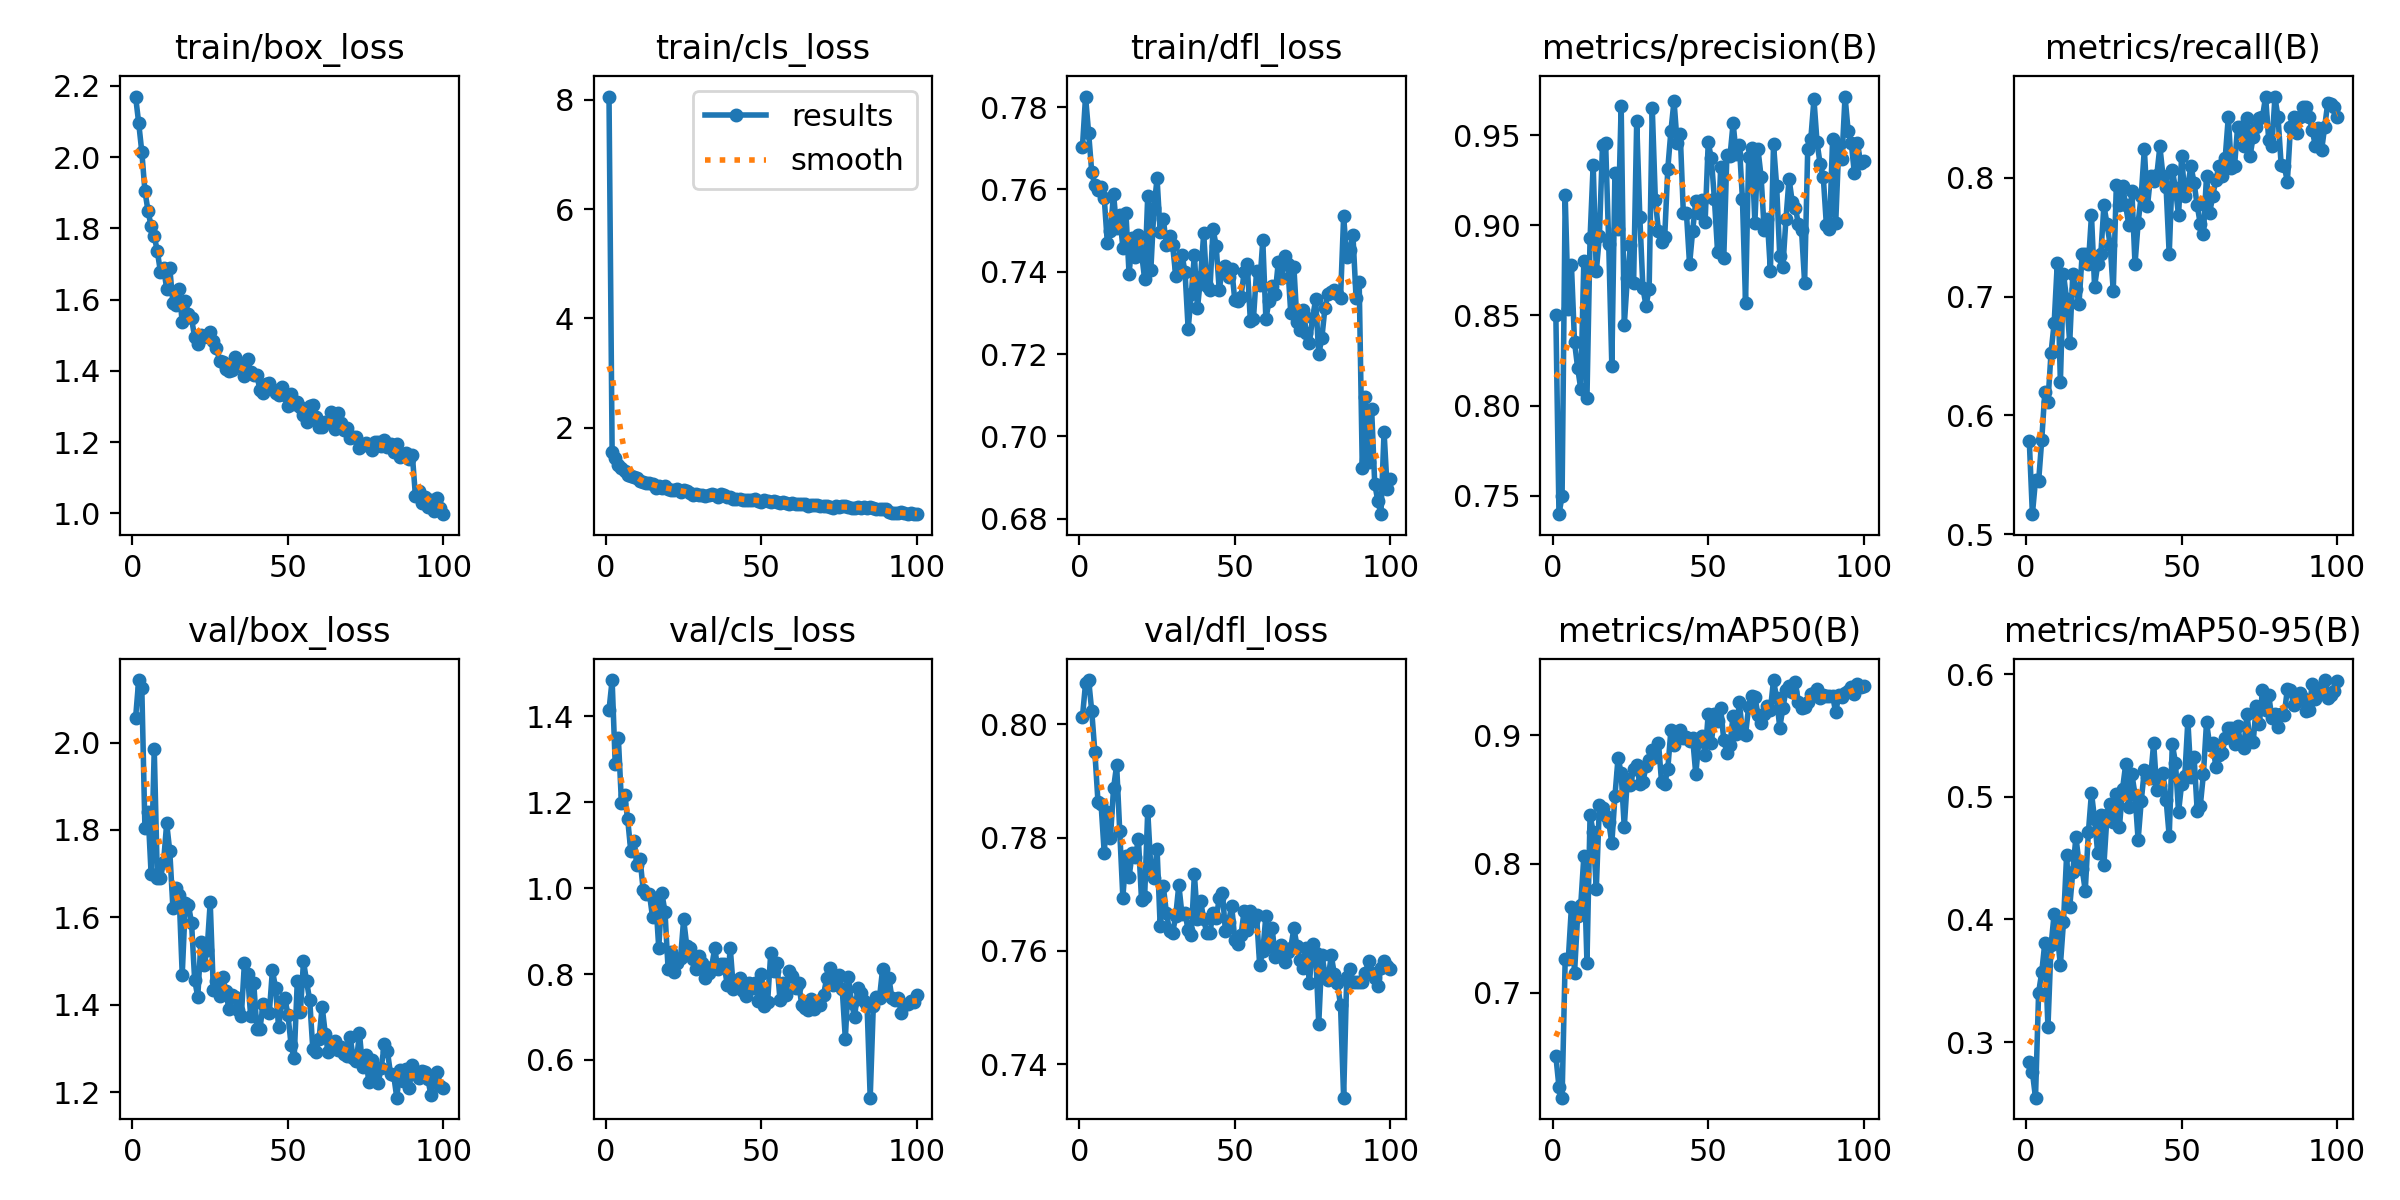

In [10]:
from IPython.display import Image, display
# Mostra gráfico de resultados (losses/mAP)
display(Image(filename=f"{RUN_DIR}/results.png", width=600))

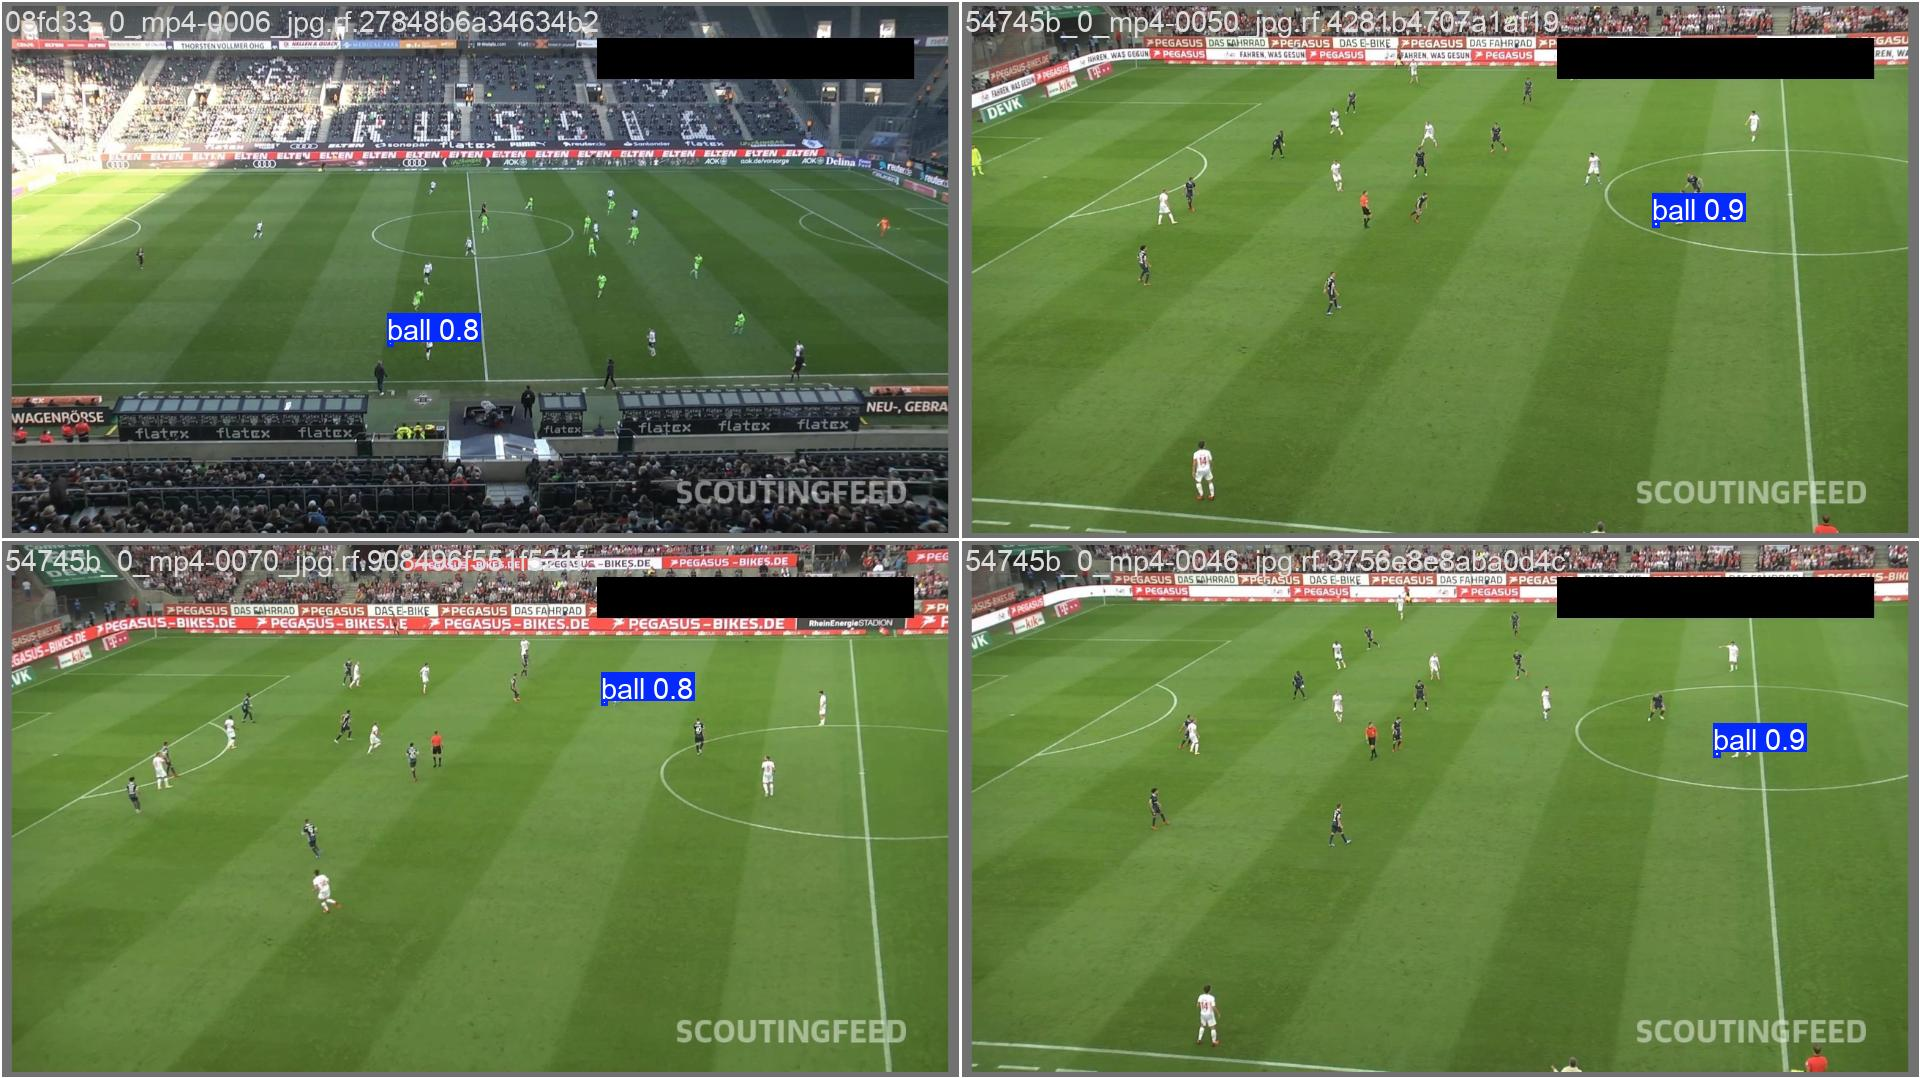

In [11]:
from IPython.display import Image, display
# Mostra predições do batch de validação
display(Image(filename=f"{RUN_DIR}/val_batch0_pred.jpg", width=600))

## Validate custom model

In [12]:
# Validação usando a API Python (evita problemas de CLI e paths com espaços)
metrics = model.val(data=data_path, imgsz=640, batch=4, device=0, workers=0)
print(f"mAP50: {metrics.box.map50:.3f}  |  mAP50-95: {metrics.box.map:.3f}")

Ultralytics 8.3.221  Python-3.11.9 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
YOLOv12s summary (fused): 159 layers, 9,231,267 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access  (ping: 0.10.1 ms, read: 875.0234.2 MB/s, size: 216.7 KB)
val: Scanning C:\Player Detection\roboflow_sports_footar\notebooks\datasets\football-ball-detection-2\valid\labels.cache... 121 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 121/121 60.9Kit/s 0.0sval: Fast image access  (ping: 0.10.1 ms, read: 875.0234.2 MB/s, size: 216.7 KB)
val: Scanning C:\Player Detection\roboflow_sports_footar\notebooks\datasets\football-ball-detection-2\valid\labels.cache... 121 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 121/121 60.9Kit/s 0.0s

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 31/31 11.5it/s 2.7s0.1s
                 Class  

In [13]:
# Comparação com treino anterior (se existir)
import os
import csv

old_results = os.path.join(HOME, "runs", "detect", "train_ball_y12s", "results.csv")
if os.path.exists(old_results):
    print("=" * 60)
    print("COMPARAÇÃO: Treino Anterior vs Atual")
    print("=" * 60)
    
    # Lê último epoch do treino anterior
    with open(old_results, 'r') as f:
        reader = csv.DictReader(f)
        old_rows = list(reader)
        old_last = old_rows[-1]
    
    print("\n📊 TREINO ANTERIOR (50 epochs, imgsz=640):")
    print(f"  Precision: {float(old_last['metrics/precision(B)']):.3f}")
    print(f"  Recall:    {float(old_last['metrics/recall(B)']):.3f}  ← PROBLEMA!")
    print(f"  mAP50:     {float(old_last['metrics/mAP50(B)']):.3f}")
    
    print("\n📊 TREINO ATUAL (validação abaixo):")
    print(f"  Esperado: Recall > 0.60, mAP50 > 0.50")
    print("=" * 60)
else:
    print("Treino anterior não encontrado (primeira execução)")

COMPARAÇÃO: Treino Anterior vs Atual

📊 TREINO ANTERIOR (50 epochs, imgsz=640):
  Precision: 0.728
  Recall:    0.298  ← PROBLEMA!
  mAP50:     0.386

📊 TREINO ATUAL (validação abaixo):
  Esperado: Recall > 0.60, mAP50 > 0.50


In [14]:
# Análise detalhada do treino atual
import csv

results_csv = os.path.join(RUN_DIR, "results.csv")

with open(results_csv, 'r') as f:
    reader = csv.DictReader(f)
    rows = list(reader)

print("\n" + "=" * 60)
print("ANÁLISE DETALHADA - TREINO OTIMIZADO")
print("=" * 60)

# Última época
last = rows[-1]
precision = float(last['metrics/precision(B)'])
recall = float(last['metrics/recall(B)'])
map50 = float(last['metrics/mAP50(B)'])
map5095 = float(last['metrics/mAP50-95(B)'])

print(f"\n📊 MÉTRICAS FINAIS (Epoch {len(rows)}):")
print(f"  Precision:  {precision:.3f} ({precision*100:.1f}%)")
print(f"  Recall:     {recall:.3f} ({recall*100:.1f}%) {'✅ MELHOROU!' if recall > 0.5 else '⚠️ Ainda baixo'}")
print(f"  mAP50:      {map50:.3f} ({map50*100:.1f}%) {'✅ BOM!' if map50 > 0.5 else '⚠️ Razoável'}")
print(f"  mAP50-95:   {map5095:.3f} ({map5095*100:.1f}%)")

# Evolução
print(f"\n📈 EVOLUÇÃO:")
checkpoints = [0, 24, 49, len(rows)-1]
for idx in checkpoints:
    if idx < len(rows):
        epoch = idx + 1
        map_val = float(rows[idx]['metrics/mAP50(B)'])
        recall_val = float(rows[idx]['metrics/recall(B)'])
        print(f"  Epoch {epoch:3d}: mAP50={map_val:.3f}, Recall={recall_val:.3f}")

# Melhor época
best_map50 = max(float(r['metrics/mAP50(B)']) for r in rows)
best_epoch = [i+1 for i, r in enumerate(rows) if float(r['metrics/mAP50(B)']) == best_map50][0]

print(f"\n🏆 MELHOR ÉPOCA: {best_epoch} (mAP50={best_map50:.3f})")
if best_epoch < len(rows):
    print(f"   ⚠️ Melhor resultado não foi no final!")
    print(f"   → Usar weights do epoch {best_epoch}: epoch{best_epoch}.pt")

print("\n" + "=" * 60)


ANÁLISE DETALHADA - TREINO OTIMIZADO

📊 MÉTRICAS FINAIS (Epoch 100):
  Precision:  0.936 (93.6%)
  Recall:     0.851 (85.1%) ✅ MELHOROU!
  mAP50:      0.938 (93.8%) ✅ BOM!
  mAP50-95:   0.595 (59.5%)

📈 EVOLUÇÃO:
  Epoch   1: mAP50=0.651, Recall=0.579
  Epoch  25: mAP50=0.861, Recall=0.777
  Epoch  50: mAP50=0.916, Recall=0.818
  Epoch 100: mAP50=0.938, Recall=0.851

🏆 MELHOR ÉPOCA: 71 (mAP50=0.943)
   ⚠️ Melhor resultado não foi no final!
   → Usar weights do epoch 71: epoch71.pt



## Copy optimized model to production

Copia o modelo treinado para o diretório `data/` onde o `main.py` espera encontrá-lo.

In [15]:
import shutil
import os

# Determina qual epoch usar (melhor ou último)
results_csv = os.path.join(RUN_DIR, "results.csv")
with open(results_csv, 'r') as f:
    reader = csv.DictReader(f)
    rows = list(reader)

best_map50 = max(float(r['metrics/mAP50(B)']) for r in rows)
best_epoch = [i+1 for i, r in enumerate(rows) if float(r['metrics/mAP50(B)']) == best_map50][0]

# Caminhos
weights_dir = os.path.join(RUN_DIR, "weights")
best_weights = os.path.join(weights_dir, "best.pt")
data_dir = os.path.join(HOME, "..", "data")
os.makedirs(data_dir, exist_ok=True)

destination = os.path.join(data_dir, "ball_y12s_optimized_best.pt")

# Copia
shutil.copy2(best_weights, destination)

print("=" * 60)
print("✅ MODELO COPIADO PARA PRODUÇÃO")
print("=" * 60)
print(f"Origem:  {best_weights}")
print(f"Destino: {destination}")
print(f"\n📝 PRÓXIMO PASSO:")
print(f"   Atualizar main.py linha ~48:")
print(f"   BALL_DETECTION_MODEL_PATH = 'data/ball_y12s_optimized_best.pt'")
print(f"\n🎯 Melhor época foi: {best_epoch}")
if best_epoch < len(rows):
    print(f"   ⚠️ Se quiser usar epoch {best_epoch} especificamente:")
    epoch_file = f"epoch{best_epoch}.pt"
    if os.path.exists(os.path.join(weights_dir, epoch_file)):
        print(f"   Copiar: {os.path.join(weights_dir, epoch_file)}")
print("=" * 60)

✅ MODELO COPIADO PARA PRODUÇÃO
Origem:  C:/Player Detection/roboflow_sports_footar/notebooks/runs/detect/train_ball_y12s_optimized2\weights\best.pt
Destino: c:\Player Detection\roboflow_sports_footar\notebooks\..\data\ball_y12s_optimized_best.pt

📝 PRÓXIMO PASSO:
   Atualizar main.py linha ~48:
   BALL_DETECTION_MODEL_PATH = 'data/ball_y12s_optimized_best.pt'

🎯 Melhor época foi: 71
   ⚠️ Se quiser usar epoch 71 especificamente:


## Optional: Deploy model on Roboflow (YOLOv8 only)

Note: Roboflow's deploy(model_type="yolov8") currently requires ultralytics==8.0.196. This notebook trains with YOLOv12 on ultralytics 8.3.x, so deploying from here will fail. You can:
- Upload the weights file manually in the Roboflow UI (Versions -> Upload Model -> YOLOv8) using RUN_DIR/weights/best.pt
- Or create a separate env with ultralytics==8.0.196 and run the deploy cell there.


In [16]:
# Guarded deploy: skip if ultralytics version is not the one required by Roboflow's deploy
import os
import ultralytics as ulx

# Resolve RUN_DIR and WEIGHTS path safely
try:
    RUN_DIR
except NameError:
    import glob
    base = os.path.join(HOME, "runs", "detect")
    # fallback: pick most recent detect run
    candidates = glob.glob(os.path.join(base, "*"))
    candidates = [p for p in candidates if os.path.isdir(p)]
    RUN_DIR = max(candidates, key=os.path.getmtime) if candidates else None

if RUN_DIR is None:
    print("No run directory found; train the model first.")
else:
    weights_path = os.path.join(RUN_DIR, "weights", "best.pt")
    need = "8.0.196"
    have = ulx.__version__
    if have == need:
        print(f"Deploying {weights_path} to Roboflow as YOLOv8 with ultralytics {have}...")
        project.version(dataset.version).deploy(model_type="yolov8", model_path=weights_path)
    else:
        print(f"Skipping deploy: Roboflow requires ultralytics=={need}, but found {have}.")
        print("Options:")
        print("  1) Upload manually in Roboflow UI: Versions -> Upload Model -> YOLOv8")
        print(f"     Weights: {weights_path}")
        print("  2) Create a separate env with ultralytics==8.0.196 and run this cell there.")

Skipping deploy: Roboflow requires ultralytics==8.0.196, but found 8.3.221.
Options:
  1) Upload manually in Roboflow UI: Versions -> Upload Model -> YOLOv8
     Weights: C:/Player Detection/roboflow_sports_footar/notebooks/runs/detect/train_ball_y12s_optimized2\weights\best.pt
  2) Create a separate env with ultralytics==8.0.196 and run this cell there.
